### 3. Házi feladat

In [187]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy import stats
import seaborn as sns

In [191]:
# ---DATA---
df = pd.read_csv("Housing.csv")
#y = df['price']
#X = df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']]
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,dfurnished,dsemifurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1,0


In [194]:
# ---MODEL DEFINITION---
model_specs = [
  ["area"], ["parking"], ["stories", "prefarea"], ["area", "stories", "prefarea"],
    ["area", "stories", "bathrooms", "prefarea"],
    ["area", "bedrooms", "mainroad", "guestroom"],
    ["area", "hotwaterheating", "airconditioning", "parking", "prefarea"],
    ["area", "bedrooms", "bathrooms", "stories", "mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "parking", "prefarea", "dfurnished", "dsemifurnished"]
]

model_lookup = pd.DataFrame({
    "model_id": np.arange(1, len(model_specs)+1, dtype=int),
    "size": [len(ix) for ix in model_specs],
    "label": ["+".join([f"{j}" for j in ix]) for ix in model_specs],
})
model_lookup.to_csv("models.csv")
model_lookup.to_latex('table.tex')

In [182]:
def rmse(actual, predicted):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    return float(np.sqrt(np.mean((actual - predicted)**2)))

def fit_ols(X, y):
    # OLS zárt forma: (X'X)^(-1) X'y  -> np.linalg.lstsq stabilabb
    beta_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta_hat

def fit_ols_with_ic(df, cols):
    X = df[cols].values
    y = df["price"].values
    Xc = sm.add_constant(X)  # intercept, mint az R-ben
    res = sm.OLS(y, Xc).fit()
    return res.aic, res.bic

def predict(beta_hat, X):
    return X @ beta_hat

def fit_multivar(data_df, var_list):
    X = data_df[var_list].values
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    y = data_df["price"].values
    beta, *_ = np.linalg.lstsq(X_with_const, y, rcond=None)
    return {"beta": beta, "variables": var_list}

def predict_multivar(model, x_new_df):
    var_list = model["variables"]
    X = x_new_df[var_list].values
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_with_const @ model["beta"]


In [155]:
# ---- DIRECT METHOD ----

rmse_tr_mat = np.full((len(model_specs)), np.nan, dtype=float)
rmse_va_mat = np.full((len(model_specs)), np.nan, dtype=float)

rng_master = np.random.default_rng(1)

# 80/20 trnval/test, majd trnval-on belül 80/20 -> 64/16/20
idx = np.arange(len(df))
rng_split = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
rng_split.shuffle(idx)
trnval_idx = idx[: int(np.floor(0.8 * len(df)))]
test_idx   = idx[int(np.floor(0.8 * len(df))):]

trnval = df.iloc[trnval_idx].reset_index(drop=True)
test   = df.iloc[test_idx].reset_index(drop=True)

idx2 = np.arange(len(trnval))
rng_split2 = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
rng_split2.shuffle(idx2)
trn_idx = idx2[: int(np.floor(0.8 * len(trnval)))]
val_idx = idx2[int(np.floor(0.8 * len(trnval))):]

trn = trnval.iloc[trn_idx].reset_index(drop=True)
val = trnval.iloc[val_idx].reset_index(drop=True)

# ---- DIREKT METHOD ---- 
for j, ix in enumerate(model_specs):
    cols = [f"{k}" for k in ix]
    X_tr = trn[cols].values
    y_tr = trn["price"].values
    bhat = fit_ols(X_tr, y_tr)

    # train RMSE
    pred_tr = predict(bhat, X_tr)
    rmse_tr_mat[j] = rmse(y_tr, pred_tr)

    # valid RMSE
    X_va = val[cols].values
    y_va = val["price"].values
    pred_va=predict(bhat, X_va)
    rmse_va_mat[j] = rmse(y_va, pred_va)

rmse_tr_mat, rmse_va_mat

(array([1807551.36532939, 3655572.71608306, 1974737.17590384,
        1366788.10405955, 1218600.65835826, 1396699.32537792,
        1537834.72752204, 1030802.24993739]),
 array([1853442.63534353, 3599062.57295517, 2096772.0165681 ,
        1463575.87714667, 1287483.27083136, 1471958.40315651,
        1588596.60629071, 1173102.81988174]))

In [196]:
# ---- INDIRECT METHOD ----

n_mods = len(model_specs)

AIC_mat = np.full((n_mods), np.nan, dtype=float)
BIC_mat = np.full((n_mods), np.nan, dtype=float)

rng_master = np.random.default_rng(3)

# ---- Szimulációk (AIC/BIC a train+validation halmazon) ----
# 80/20 split -> trnval/test
idx = np.arange(len(df))
rng_split = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
rng_split.shuffle(idx)
cut = int(np.floor(0.8*len(df)))
trnval = df.iloc[idx[:cut]].reset_index(drop=True)
test = df.iloc[idx[cut:]].reset_index(drop=True)
    
# illesztés és IC-k számítása trnval-on
aic_vals = np.empty(n_mods, dtype=float)
bic_vals = np.empty(n_mods, dtype=float)
for j, ix in enumerate(model_specs):
    cols = [f"{k}" for k in ix]
    aic, bic = fit_ols_with_ic(trnval, cols)
    aic_vals[j] = aic
    bic_vals[j] = bic
    
AIC_mat[:] = aic_vals
BIC_mat[:] = bic_vals
aic_pick = int(np.argmin(aic_vals)) + 1  # model_id (1-indexelt)
bic_pick = int(np.argmin(bic_vals)) + 1

# print(AIC_mat, BIC_mat, aic_pick, bic_pick) # ????


# ---- LASSO REGULARIZATION ----

rmse_lasso = []
alp = 24141

for j, ix in enumerate(model_specs):
    cols = [f"{k}" for k in ix]
    X_tr = trn[cols].values
    y_tr = trn["price"].values
    X_te = test[cols].values
    Y_te=test["price"].values
     
    lasso = Lasso(alpha = alp)
    lasso.fit(X_tr, y_tr)
    pred_te = lasso.predict(X_te)
    rmse_lasso.append(rmse(Y_te, pred_te))

lasso_pick = int(np.argmin(rmse_lasso))+1
print(rmse_lasso)
print(lasso_pick)


[1699072.5960535454, 1866437.146493226, 1612414.0316368744, 1413878.475406674, 1261059.5933864901, 1574119.8655644043, 1435135.4682638336, 1155102.7146463]
8


In [236]:
# ---- Átlag RMSE-k és táblázat ----
avg_df = pd.concat([
    pd.DataFrame({
        "model_id": model_lookup["model_id"].values,
        "set": "Train",
        "rmse": rmse_tr_mat
    }),
    pd.DataFrame({
        "model_id": model_lookup["model_id"].values,
        "set": "Validation",
        "rmse": rmse_va_mat
    })
], ignore_index=True).merge(model_lookup, on="model_id", how="left")

best_id_avg = int(avg_df[avg_df["set"]=="Validation"].sort_values("rmse").iloc[0]["model_id"])
best_label = model_lookup.loc[model_lookup["model_id"]==best_id_avg, "label"].item()

print(best_id_avg)
avg_df.to_latex("rmse.tex")
avg_df

8


,model_id,set,rmse,size,label
0,1,Train,1.807551e+06,1,area
1,2,Train,3.655573e+06,1,parking
2,3,Train,1.974737e+06,2,stories+prefarea
3,4,Train,1.366788e+06,3,area+stories+prefarea
4,5,Train,1.218601e+06,4,area+stories+bathrooms+prefarea
5,6,Train,1.396699e+06,4,area+bedrooms+mainroad+guestroom
6,7,Train,1.537835e+06,5,area+hotwaterheating+airconditioning+parking+p...
7,8,Train,1.030802e+06,13,area+bedrooms+bathrooms+stories+mainroad+guest...
8,1,Validation,1.853443e+06,1,area
9,2,Validation,3.599063e+06,1,parking


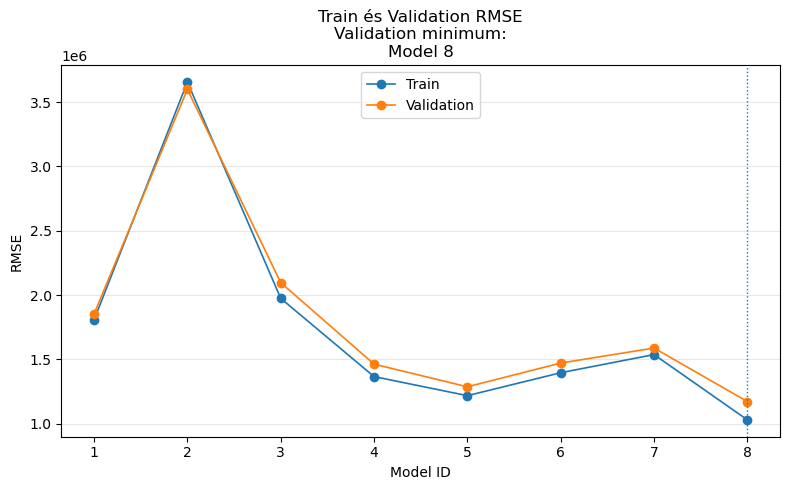

In [200]:
# ---- ÁBRA: CSAK átlag RMSE ----
fig, ax = plt.subplots(figsize=(8,5))
for label, dfp in avg_df.groupby("set"):
    ax.plot(dfp["model_id"], dfp["rmse"], marker="o", linewidth=1.2, label=label)

ax.axvline(best_id_avg, linestyle=":", linewidth=1.0)
ax.set_xticks(model_lookup["model_id"].values)
ax.set_xlabel("Model ID"); ax.set_ylabel("RMSE")
ax.set_title("Train és Validation RMSE\nValidation minimum:\nModel %d" % (best_id_avg))
ax.legend(loc="upper center")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("direkt.pdf")
plt.show()

In [214]:
avg_df = pd.concat([
    pd.DataFrame({"model_id": model_lookup["model_id"].values, "crit": "AIC", "ic": AIC_mat}),
    pd.DataFrame({"model_id": model_lookup["model_id"].values, "crit": "BIC", "ic": BIC_mat})
], ignore_index=True).merge(model_lookup, on="model_id", how="left")

aic_df = pd.DataFrame({"model_id": model_lookup["model_id"].values, "crit": "AIC", "ic": AIC_mat})
bic_df = pd.DataFrame({"model_id": model_lookup["model_id"].values, "crit": "BIC", "ic": BIC_mat})

avg_df.sort_values(by='ic')[['model_id', 'crit', 'size']].to_latex("aic_bic.tex")


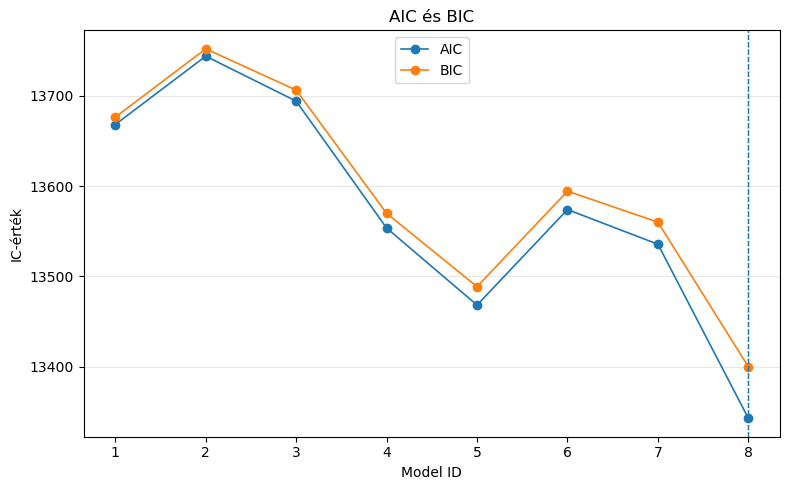

In [160]:
# ---- ÁBRA: csak átlag IC-k ----
fig, ax = plt.subplots(figsize=(8,5))
for label, dfp in avg_df.groupby("crit"):
    ax.plot(dfp["model_id"], dfp["ic"], marker="o", linewidth=1.2, label=label)

ax.axvline(best_aic, linestyle=":", linewidth=1.0)
ax.axvline(best_bic, linestyle="--", linewidth=1.0)
ax.set_xticks(model_lookup["model_id"].values)
ax.set_title("AIC és BIC")
ax.set_xlabel("Model ID"); ax.set_ylabel("IC-érték")
ax.legend(loc="upper center")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [168]:
# ---- CROSS VALIDATION ----

# ---- DIRECT METHOD ----



# ---- LASSO 5 FOLD CV ----

# a legbővebb modellre hívd meg

X_tv = trnval[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']].values
y_tv = trnval["price"].values
X_te = test[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']].values
Y_te = test[["price"]].values
lcv = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LassoCV(cv=5, random_state=int(rng_master.integers(0,1_000_000)), n_alphas=100)  # fixed
)
lcv.fit(X_tv, y_tv)
yhat_lasso = lcv.predict(X_te)
coef = lcv.named_steps["lassocv"].coef_
lasso_df = int((np.abs(coef)>1e-12).sum())
    
rmse_lasso = rmse(Y_te, yhat_lasso)
    
print(rmse_lasso)
print(lcv.named_steps["lassocv"].alpha_)
print(lasso_df)

2540893.806388948
1009.1191047037255
13


Szimuláció futtatása 100 ismétléssel az eloszlás ábrákhoz...


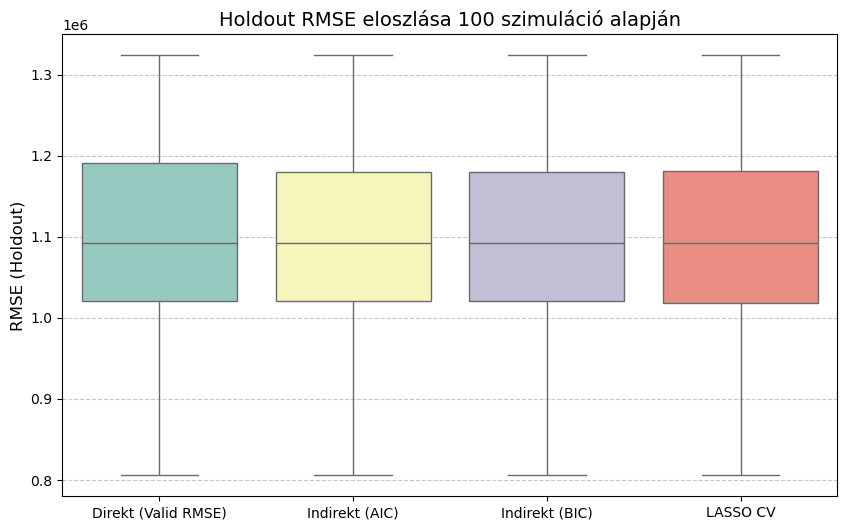

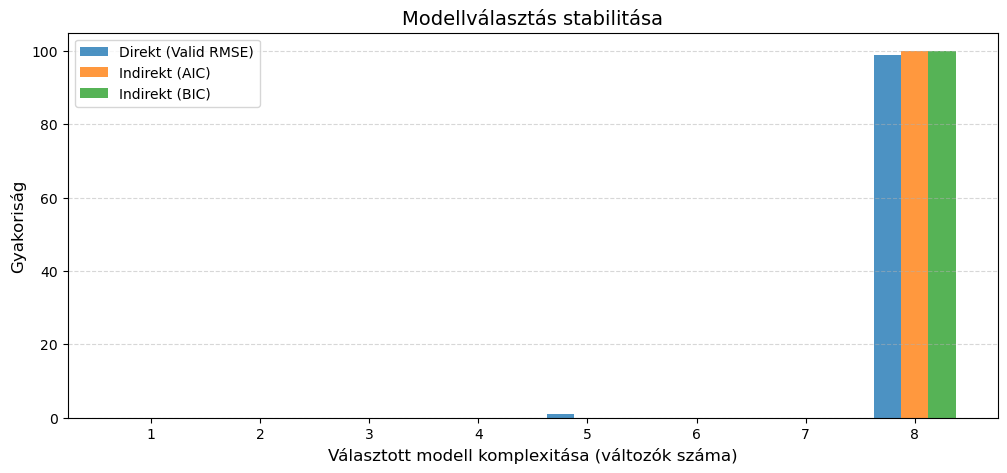

1097324.9674437454
1096453.7778493152
1096453.7778493152
1096704.2059947355
0.001520985799439796

112776.16901154733
111817.83894740672
111817.83894740672
112608.01094000616
0.0017052854012016255
{'beta': array([-4.54756163e+05,  2.16895237e+02,  1.90030097e+05,  9.22675233e+05,
        4.40031552e+05,  5.93924772e+05,  1.77990322e+05,  3.92757215e+05,
        6.40875881e+05,  9.51843916e+05,  2.76626596e+05,  5.89000788e+05,
        3.88402422e+05,  2.40495652e+05]), 'variables': ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']}


In [241]:
# --- 2. SZIMULÁCIÓ (100x ismétlés) ---
n_sims = 100
rng = np.random.default_rng(42)

# Tárolók az eredményeknek
results_rmse = {
    "Direkt (Valid RMSE)": [],
    "Indirekt (AIC)": [],
    "Indirekt (BIC)": [],
    "LASSO CV": []
}

results_selection = {
    "Direkt (Valid RMSE)": [],
    "Indirekt (AIC)": [],
    "Indirekt (BIC)": [],
    "LASSO CV (Vars)": []
}

lasso_alpha = []

print(f"Szimuláció futtatása {n_sims} ismétléssel az eloszlás ábrákhoz...")

for s in range(n_sims):
    # Split
    idx = np.arange(len(df))
    rng.shuffle(idx)
    work = df.iloc[idx[:int(0.8*len(df))]].reset_index(drop=True)
    test = df.iloc[idx[int(0.8*len(df)):]].reset_index(drop=True)
    
    idx2 = np.arange(len(work))
    rng.shuffle(idx2)
    trn = work.iloc[idx2[:int(0.8*len(work))]].reset_index(drop=True)
    val = work.iloc[idx2[int(0.8*len(work)):]].reset_index(drop=True)
    
    # 1-3. Módszerek (Direkt, AIC, BIC)
    val_rmses = []
    aics = []
    bics = []
    
    for j, cols in enumerate(model_specs):
        # Direkt
        mod = fit_multivar(trn, cols)
        pred_v = predict_multivar(mod, val)
        val_rmses.append(rmse(val["price"], pred_v))
        
        # IC
        aic, bic = fit_ols_with_ic(work, cols)
        aics.append(aic)
        bics.append(bic)
        
    # Kiválasztás és Kiértékelés
    
    # Direkt
    best_idx = np.argmin(val_rmses)
    mod_fin = fit_multivar(work, model_specs[best_idx])
    results_rmse["Direkt (Valid RMSE)"].append(rmse(test["price"], predict_multivar(mod_fin, test)))
    results_selection["Direkt (Valid RMSE)"].append(best_idx + 1)
    
    # AIC
    best_idx = np.argmin(aics)
    mod_fin = fit_multivar(work, model_specs[best_idx])
    results_rmse["Indirekt (AIC)"].append(rmse(test["price"], predict_multivar(mod_fin, test)))
    results_selection["Indirekt (AIC)"].append(best_idx + 1)

    # BIC
    best_idx = np.argmin(bics)
    mod_fin = fit_multivar(work, model_specs[best_idx])
    results_rmse["Indirekt (BIC)"].append(rmse(test["price"], predict_multivar(mod_fin, test)))
    results_selection["Indirekt (BIC)"].append(best_idx + 1)
    
    # 4. LASSO (JAVÍTVA: Külön scaler X-nek és y-nak)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_work_sc = scaler_X.fit_transform(work[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']])
    y_work_sc = scaler_y.fit_transform(work[['price']]).flatten()
    
    X_test_sc = scaler_X.transform(test[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']])
    
    lcv = LassoCV(cv=5, random_state=int(rng.integers(0,1e6))).fit(X_work_sc, y_work_sc)
    pred_sc = lcv.predict(X_test_sc)
    pred = scaler_y.inverse_transform(pred_sc.reshape(-1,1)).flatten()
    lasso_alpha.append(lcv.alpha_)
    
    results_rmse["LASSO CV"].append(rmse(test["price"], pred))
    
    # Hány változót tartott meg?
    n_vars = np.sum(np.abs(lcv.coef_) > 1e-10)
    results_selection["LASSO CV (Vars)"].append(n_vars)

# DataFrame konverzió
df_rmse_res = pd.DataFrame(results_rmse)
df_sel_res = pd.DataFrame(results_selection)

# --- 3. ÁBRÁZOLÁS ---

# 1. ÁBRA: Holdout RMSE Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_rmse_res, palette="Set3")
plt.title('Holdout RMSE eloszlása 100 szimuláció alapján', fontsize=14)
plt.ylabel('RMSE (Holdout)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig("holdout.pdf")
plt.show()

# 2. ÁBRA: Kiválasztott modellek eloszlása
methods_to_plot = ["Direkt (Valid RMSE)", "Indirekt (AIC)", "Indirekt (BIC)"]
plt.figure(figsize=(12, 5))

width = 0.25
x = np.arange(1, 9) 

for i, method in enumerate(methods_to_plot):
    counts = df_sel_res[method].value_counts().reindex(x, fill_value=0)
    plt.bar(x + (i-1)*width, counts, width=width, label=method, alpha=0.8)

plt.title('Modellválasztás stabilitása', fontsize=14)
plt.xlabel('Választott modell komplexitása (változók száma)', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.xticks(x)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig("stability.pdf")
plt.show()

# print(df_rmse_res)
print(np.mean(df_rmse_res[["Direkt (Valid RMSE)"]].values))
print(np.mean(df_rmse_res[["Indirekt (AIC)"]].values))
print(np.mean(df_rmse_res[["Indirekt (BIC)"]].values))
print(np.mean(df_rmse_res[["LASSO CV"]].values))
print(np.mean(lasso_alpha))
print()
print(np.std(df_rmse_res[["Direkt (Valid RMSE)"]].values))
print(np.std(df_rmse_res[["Indirekt (AIC)"]].values))
print(np.std(df_rmse_res[["Indirekt (BIC)"]].values))
print(np.std(df_rmse_res[["LASSO CV"]].values))
print(np.std(lasso_alpha))

print(mod)